In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
start_date = '2017-06-12'

end_date='2021-03-31'


In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]") \
                    .getOrCreate()

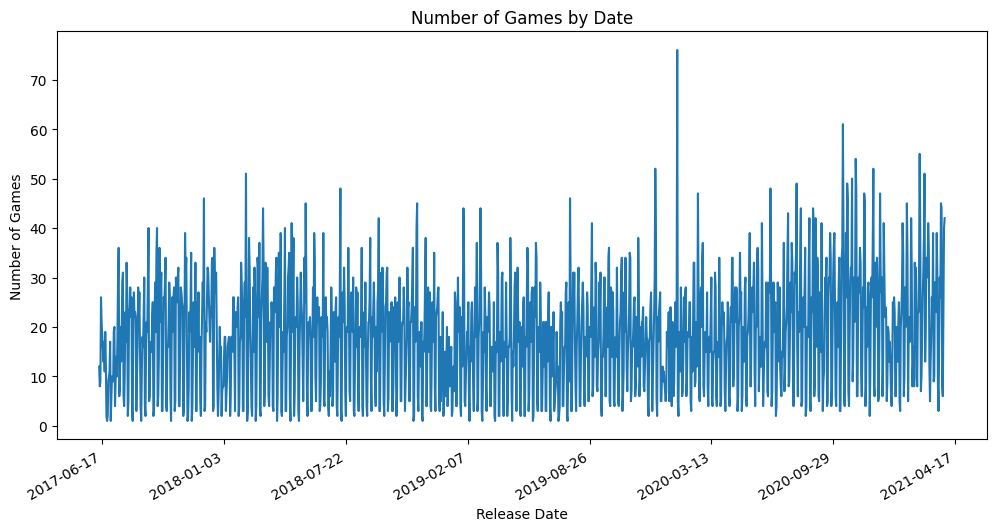

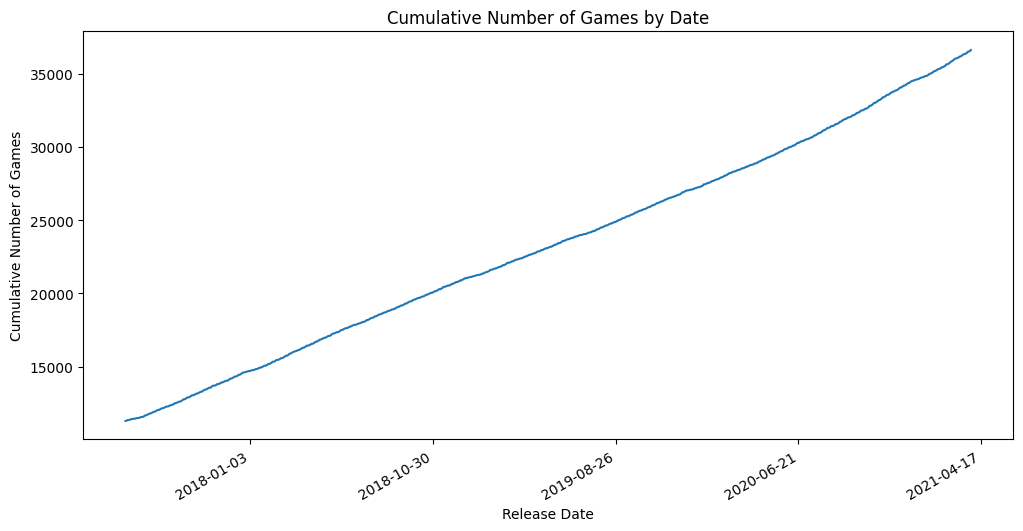

In [3]:
from pyspark.sql.functions import to_date, date_format,sum
from pyspark.sql.window import Window

df = spark.read.option("delimiter", ",").option('header', 'true').csv("Data/merged_data.csv")
# Convert 'Release Date' to date type
df = df.withColumn('Release Date', to_date(df['Release Date'], 'd MMM, yyyy'))
# Format 'Release Date' in the desired format
df = df.withColumn('Release Date', date_format(df['Release Date'], 'yyyy-MM-dd'))

# Filter out None values
df = df.filter(df['Release Date'].isNotNull())

# df = df.filter(df['Release Date'] >= start_date)
df = df.filter(df['Release Date'] <= end_date)

df = df.orderBy(df['Release Date'].asc()) #asc desc



# Continue with your operations
df_MD = df.rdd

df_MD_loc = df_MD.map(lambda r: (r['Title'],r['Release Date']))
# df_MD_loc = df_MD_loc.filter(lambda t:start_date<= t[1] <= end_date)

df_MD_loc.take(10)


import matplotlib.pyplot as plt

# Count the number of games by date
df_count = df.groupBy('Release Date').count()

df_count_plot = df_count.filter(df['Release Date'] >= start_date)

# Collect the data to the driver node
data = df_count_plot.orderBy('Release Date').collect()

# Separate the data into two lists for plotting
dates = [row['Release Date'] for row in data]
counts = [row['count'] for row in data]

dates = [mdates.datestr2num(i) for i in dates]

# Plot
plt.figure(figsize=(12,6))
plt.plot(dates, counts)
plt.xlabel('Release Date')
plt.ylabel('Number of Games')
plt.title('Number of Games by Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))  # set interval to 7 days for example
plt.gcf().autofmt_xdate()  # autoformat the x-axis date label for better readability

plt.show()

# Define a window specification
windowSpec = Window.orderBy('Release Date')

# Calculate the cumulative count
df_count = df_count.withColumn('cumulative_count', sum('count').over(windowSpec))

df_count_plot = df_count.filter(df['Release Date'] >= start_date)

# Collect the data to the driver node
data = df_count_plot.orderBy('Release Date').collect()

# Separate the data into two lists for plotting
dates = [row['Release Date'] for row in data]
counts = [row['cumulative_count'] for row in data]
dates = [mdates.datestr2num(i) for i in dates]

# Plot
plt.figure(figsize=(12,6))
plt.plot(dates, counts)
plt.xlabel('Release Date')
plt.ylabel('Cumulative Number of Games')
plt.title('Cumulative Number of Games by Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=300))  # set interval to 7 days for example
plt.gcf().autofmt_xdate()  # autoformat the x-axis date label for better readability

plt.show()

In [4]:
# months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# df_MD_loc = df_MD.map(lambda r: (r['Release Date']))
# df_MD_loc.take(10)

In [5]:
df = spark.read.option("delimiter", ",").option('header', 'true').csv("Data/NASDAQDay.csv")
print(df.describe())
df_NAS = df.rdd

df_NAS.take(10)


DataFrame[summary: string, Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string]


[Row(Date='1971-02-05', Open='100.000000', High='100.000000', Low='100.000000', Close='100.000000', Adj Close='100.000000', Volume='0'),
 Row(Date='1971-02-08', Open='100.839996', High='100.839996', Low='100.839996', Close='100.839996', Adj Close='100.839996', Volume='0'),
 Row(Date='1971-02-09', Open='100.760002', High='100.760002', Low='100.760002', Close='100.760002', Adj Close='100.760002', Volume='0'),
 Row(Date='1971-02-10', Open='100.690002', High='100.690002', Low='100.690002', Close='100.690002', Adj Close='100.690002', Volume='0'),
 Row(Date='1971-02-11', Open='101.449997', High='101.449997', Low='101.449997', Close='101.449997', Adj Close='101.449997', Volume='0'),
 Row(Date='1971-02-12', Open='102.050003', High='102.050003', Low='102.050003', Close='102.050003', Adj Close='102.050003', Volume='0'),
 Row(Date='1971-02-16', Open='102.190002', High='102.190002', Low='102.190002', Close='102.190002', Adj Close='102.190002', Volume='0'),
 Row(Date='1971-02-17', Open='101.739998'

In [6]:
scale=50
df_NAS_loc = df_NAS.map(lambda r: (r['Date'],float(r['High'])/scale,float(r['Low'])/scale)) #float(r['Open']),float(r['High']),float(r['Low']),float(r['Close']),int(r['Volume'])
df_NAS_loc = df_NAS_loc.filter(lambda t:start_date<= t[0] <= end_date)

df_NAS_loc.take(10)

[('2017-06-12', 123.67620118, 122.21339844),
 ('2017-06-13', 124.52820312, 123.60080078000001),
 ('2017-06-14', 124.75059569999999, 123.07099609999999),
 ('2017-06-15', 123.40299804, 122.15700196),
 ('2017-06-16', 123.23120118000001, 122.51),
 ('2017-06-19', 124.86620118, 123.88),
 ('2017-06-20', 124.68019532, 123.73879882),
 ('2017-06-21', 124.73320312, 124.01719725999999),
 ('2017-06-22', 125.15360351999999, 124.43919921999999),
 ('2017-06-23', 125.38740234000001, 124.37559569999999)]

C:\Users\joshu\AppData\Local\Temp\ipykernel_11220\1998565852.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')
C:\Users\joshu\AppData\Local\Temp\ipykernel_11220\1998565852.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')


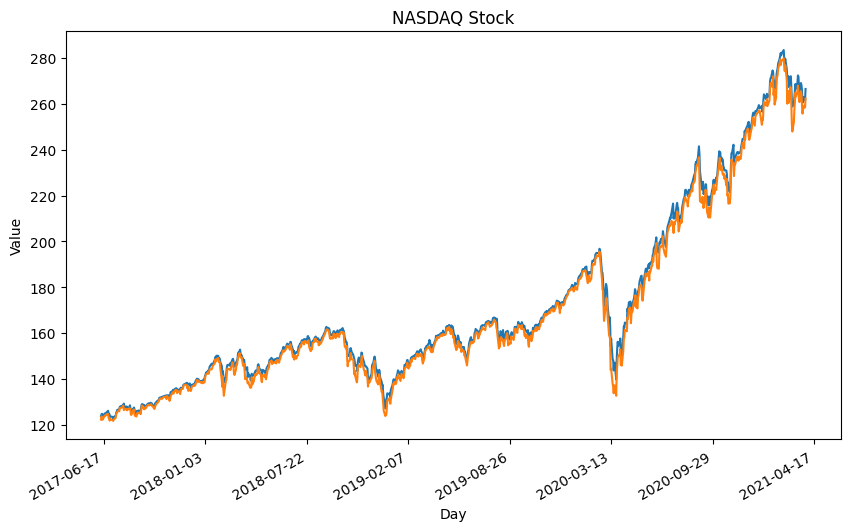

In [7]:
x=df_NAS_loc.map(lambda t: t[0]).collect()
y1=df_NAS_loc.map(lambda t: t[1]).collect()
y2=df_NAS_loc.map(lambda t: t[2]).collect()



# Convert 'x' to datetime format
x = [mdates.datestr2num(i) for i in x]

plt.figure(figsize=(10, 6))
# Plot y1 (high)
plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')

# Plot y2 (low)
plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('NASDAQ Stock')

# Format the x-axis to display dates in a more readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))  # set interval to 7 days for example
plt.gcf().autofmt_xdate()  # autoformat the x-axis date label for better readability

plt.show()


In [8]:

df = spark.read.option("delimiter", ",").option('header', 'true').csv("Data/Microsoft_Stock.csv")
print(df.describe())
df_MS = df.rdd


df_MS.take(10)


DataFrame[summary: string, Date: string, Open: string, High: string, Low: string, Close: string, Volume: string]


[Row(Date='4/1/2015 16:00:00', Open='40.6', High='40.76', Low='40.31', Close='40.72', Volume='36865322'),
 Row(Date='4/2/2015 16:00:00', Open='40.66', High='40.74', Low='40.12', Close='40.29', Volume='37487476'),
 Row(Date='4/6/2015 16:00:00', Open='40.34', High='41.78', Low='40.18', Close='41.55', Volume='39223692'),
 Row(Date='4/7/2015 16:00:00', Open='41.61', High='41.91', Low='41.31', Close='41.53', Volume='28809375'),
 Row(Date='4/8/2015 16:00:00', Open='41.48', High='41.69', Low='41.04', Close='41.42', Volume='24753438'),
 Row(Date='4/9/2015 16:00:00', Open='41.25', High='41.62', Low='41.25', Close='41.48', Volume='25723861'),
 Row(Date='4/10/2015 16:00:00', Open='41.63', High='41.95', Low='41.41', Close='41.72', Volume='28022002'),
 Row(Date='4/13/2015 16:00:00', Open='41.4', High='42.06', Low='41.39', Close='41.76', Volume='30276692'),
 Row(Date='4/14/2015 16:00:00', Open='41.8', High='42.03', Low='41.39', Close='41.65', Volume='24244382'),
 Row(Date='4/15/2015 16:00:00', Open=

In [9]:

df_MS_loc = df_MS.map(lambda r: (r['Date'],float(r['High']),float(r['Low']))) #float(r['Open']),float(r['High']),float(r['Low']),float(r['Close']),int(r['Volume'])
df_MS_loc = df_MS_loc.map(lambda r: (r[0].split(' ')[0].split('/')[2] + '-' + r[0].split(' ')[0].split('/')[0].zfill(2) + '-' + r[0].split(' ')[0].split('/')[1].zfill(2), r[1], r[2]))
df_MS_loc = df_MS_loc.filter(lambda t:start_date<= t[0] <= end_date)

df_MS_loc.take(10)

[('2017-06-12', 69.94, 68.13),
 ('2017-06-13', 70.82, 69.96),
 ('2017-06-14', 71.1, 69.43),
 ('2017-06-15', 70.21, 68.8),
 ('2017-06-16', 70.03, 69.22),
 ('2017-06-19', 70.94, 70.35),
 ('2017-06-20', 70.87, 69.87),
 ('2017-06-21', 70.62, 69.94),
 ('2017-06-22', 70.59, 69.71),
 ('2017-06-23', 71.25, 69.92)]

C:\Users\joshu\AppData\Local\Temp\ipykernel_11220\1510924214.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')
C:\Users\joshu\AppData\Local\Temp\ipykernel_11220\1510924214.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')


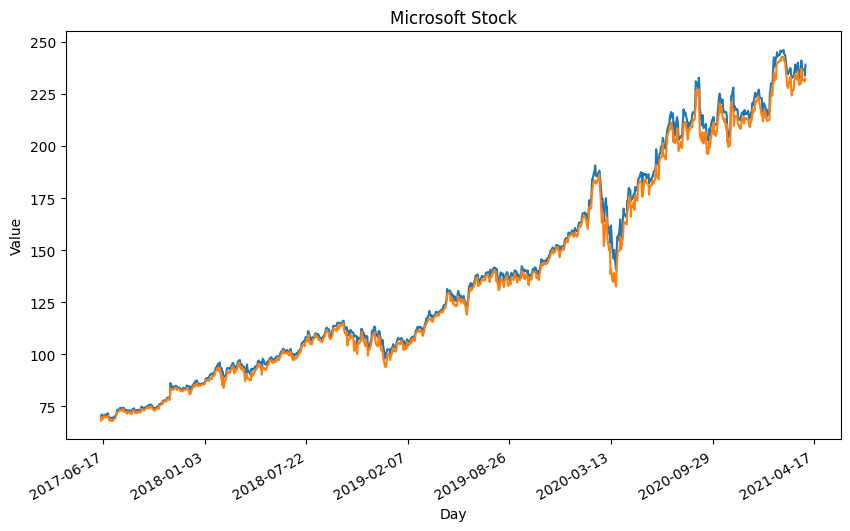

In [10]:
x=df_MS_loc.map(lambda t: t[0]).collect()
y1=df_MS_loc.map(lambda t: t[1]).collect()
y2=df_MS_loc.map(lambda t: t[2]).collect()



# Convert 'x' to datetime format
x = [mdates.datestr2num(i) for i in x]

plt.figure(figsize=(10, 6))
# Plot y1 (high)
plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')

# Plot y2 (low)
plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Microsoft Stock')

# Format the x-axis to display dates in a more readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))  # set interval to 7 days for example
plt.gcf().autofmt_xdate()  # autoformat the x-axis date label for better readability

plt.show()


In [11]:
df = spark.read.option("delimiter", ",").option('header', 'true').csv("Data/NVDA.csv")
print(df.describe())
df_NVDA = df.rdd

df_NVDA.take(10)


DataFrame[summary: string, Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string]


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 32.0 failed 1 times, most recent failure: Lost task 0.0 in stage 32.0 (TID 24) (192.168.56.1 executor driver): java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:328)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:355)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:808)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:181)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:328)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:355)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:808)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:181)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [ ]:
df_NVDA_loc= df_NVDA.map(lambda r: (r['Date'],float(r['High']),float(r['Low']))) #float(r['Open']),float(r['High']),float(r['Low']),float(r['Close']),int(r['Volume'])

df_NVDA_loc = df_NVDA_loc.filter(lambda t:start_date<= t[0] <= end_date)


df_NVDA_loc.take(10)


[('2017-06-12', 37.924999, 35.5275),
 ('2017-06-13', 38.692501, 36.412498),
 ('2017-06-14', 38.514999, 37.125),
 ('2017-06-15', 38.400002, 36.625),
 ('2017-06-16', 38.674999, 37.560001),
 ('2017-06-19', 39.3825, 38.314999),
 ('2017-06-20', 40.435001, 39.23),
 ('2017-06-21', 39.904999, 38.924999),
 ('2017-06-22', 40.084999, 39.349998),
 ('2017-06-23', 39.830002, 38.305)]

C:\Users\joshu\AppData\Local\Temp\ipykernel_20792\1399624627.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')
C:\Users\joshu\AppData\Local\Temp\ipykernel_20792\1399624627.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')


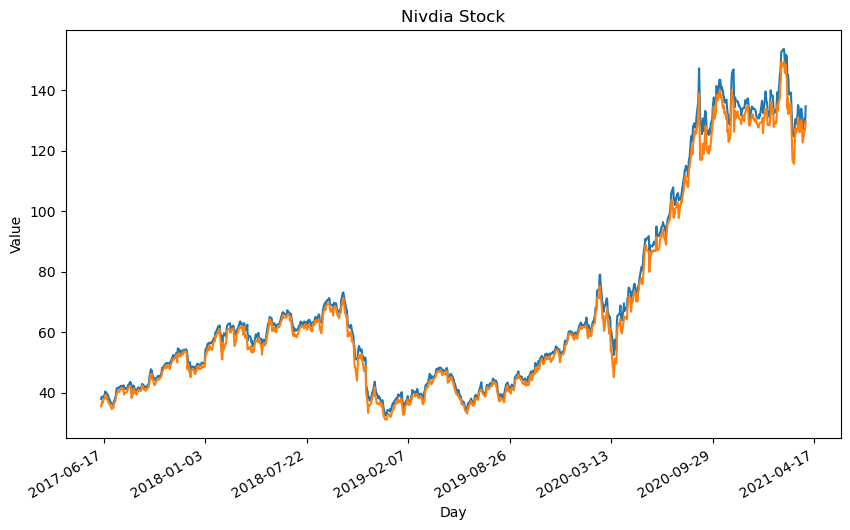

In [ ]:
x=df_NVDA_loc.map(lambda t: t[0]).collect()
y1=df_NVDA_loc.map(lambda t: t[1]).collect()
y2=df_NVDA_loc.map(lambda t: t[2]).collect()


# Convert 'x' to datetime format
x = [mdates.datestr2num(i) for i in x]

plt.figure(figsize=(10, 6))
# Plot y1 (high)
plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')

# Plot y2 (low)
plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Nivdia Stock')

# Format the x-axis to display dates in a more readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) 
plt.gcf().autofmt_xdate()  # autoformat the x-axis date label for better readability

plt.show()

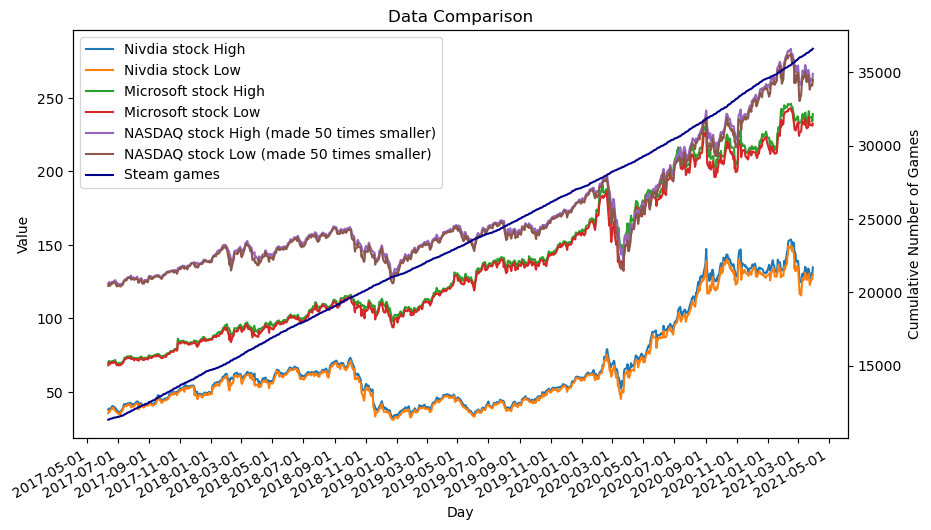

In [ ]:
plt.figure(figsize=(10, 6))

plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Data Comparison')


x1=df_NVDA_loc.map(lambda t: t[0]).collect()
y11=df_NVDA_loc.map(lambda t: t[1]).collect()
y12=df_NVDA_loc.map(lambda t: t[2]).collect()

x1 = [mdates.datestr2num(i) for i in x1]


x2=df_MS_loc.map(lambda t: t[0]).collect()
y21=df_MS_loc.map(lambda t: t[1]).collect()
y22=df_MS_loc.map(lambda t: t[2]).collect()

x2 = [mdates.datestr2num(i) for i in x2]

x3=df_NAS_loc.map(lambda t: t[0]).collect()
y31=df_NAS_loc.map(lambda t: t[1]).collect()
y32=df_NAS_loc.map(lambda t: t[2]).collect()

x3 = [mdates.datestr2num(i) for i in x3]

# Plot y1 (high)
plt.plot(x1, y11, label='Nivdia stock High')

# Plot y2 (low)
plt.plot(x1, y12, label='Nivdia stock Low')

# Plot y1 (high)
plt.plot(x2, y21, label='Microsoft stock High')

# Plot y2 (low)
plt.plot(x2, y22, label='Microsoft stock Low')


# Plot y1 (high)
plt.plot(x3, y31, label=f'NASDAQ stock High (made {scale} times smaller)')

# Plot y2 (low)
plt.plot(x3, y32, label=f'NASDAQ stock Low (made {scale} times smaller)')

handles1, labels1 = plt.gca().get_legend_handles_labels()

# Create a secondary y-axis
ax2 = plt.gca().twinx()

# Plot on the secondary y-axis
ax2.plot(dates, counts,color='darkblue', label='Steam games') #, color='green'

# Set the y-label for the secondary y-axis
ax2.set_ylabel('Cumulative Number of Games')

# Get the legend handles and labels for the first plot

# Get the legend handles and labels for the second plot (ax2)
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine the handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create a single legend
plt.legend(handles, labels)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  
plt.gcf().autofmt_xdate()  # autoformat the x-axis date label for better readability

plt.show()
